In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10354382322654704667
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5148429011661756459
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
#"""이전것 import부분 tf.으로 다 바꿔줌"""#
#""" from keras.models import Sequential"""
#""" from keras import layers"""
#""" from keras.optimizers import RMSprop"""

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

with tf.device('/device:GPU:0'):

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

import librosa 
import librosa.display
import pylab
import matplotlib.pyplot as plt
import cv2
import os

---
# 1-Prepare Data
---



## Prepare dataset

+  coughvid 

In [ ]:
import pickle #저장해놓은 데이터 열기

data_seg = {}
data_seg['data'] = []
data_seg['covid_status'] = []

with open('/content/drive/MyDrive/COVID19/rec_normalized2606.pickle', 'rb') as f:
    #파일을 열고 닫는 것을 자동으로 처리
    data_seg = pickle.load(f)
    


In [ ]:
ds_rec = pd.DataFrame.from_dict(data_seg)
#data segement를 받아 DataFrame반환 = ds

#print(ds.values)

is_healthy_seg = ds_rec['covid_status'] == 'healthy'
healthy_seg = ds_rec[is_healthy_seg]
len_healthy_seg = len(healthy_seg)

is_covid_seg = ds_rec['covid_status'] == 'COVID-19'
covid_seg = ds_rec[is_covid_seg]
len_covid_seg = len(covid_seg)

print(len_healthy_seg)
print(len_covid_seg)

#pd.set_option('display.max_rows', None)
ds_rec

2820
2502


,id,data,covid_status
0,covid1,"[0.3228007, 0.20623256, 0.054493707, -0.042205...",COVID-19
1,covid1,"[0.29663646, 0.2917977, 0.21555875, 0.13397767...",COVID-19
2,covid1,"[0.2948269, 0.2106215, 0.14394367, 0.10086444,...",COVID-19
3,covid2,"[-0.3327151, -0.35622767, -0.3278327, -0.25337...",COVID-19
4,covid2,"[-0.38657144, -0.284545, 0.10968096, 0.3772831...",COVID-19
...,...,...,...
5317,healthy1332,"[-0.4408195, -0.18619484, 0.37586033, -0.14599...",healthy
5318,healthy1332,"[0.3419352, 0.10805897, -0.27906737, -0.054883...",healthy
5319,healthy1332,"[0.38357088, 0.21126823, 0.11985815, 0.1246088...",healthy
5320,covid1275,"[-0.24705254, -0.19288902, -0.112712115, -0.03...",COVID-19


In [ ]:
ds_rec['num'] = ds_rec.index

In [ ]:
ds_rec

,id,data,covid_status,num
0,covid1,"[0.3228007, 0.20623256, 0.054493707, -0.042205...",COVID-19,0
1,covid1,"[0.29663646, 0.2917977, 0.21555875, 0.13397767...",COVID-19,1
2,covid1,"[0.2948269, 0.2106215, 0.14394367, 0.10086444,...",COVID-19,2
3,covid2,"[-0.3327151, -0.35622767, -0.3278327, -0.25337...",COVID-19,3
4,covid2,"[-0.38657144, -0.284545, 0.10968096, 0.3772831...",COVID-19,4
...,...,...,...,...
5317,healthy1332,"[-0.4408195, -0.18619484, 0.37586033, -0.14599...",healthy,5317
5318,healthy1332,"[0.3419352, 0.10805897, -0.27906737, -0.054883...",healthy,5318
5319,healthy1332,"[0.38357088, 0.21126823, 0.11985815, 0.1246088...",healthy,5319
5320,covid1275,"[-0.24705254, -0.19288902, -0.112712115, -0.03...",COVID-19,5320


받은 데이터

In [ ]:
print(ds_rec.values[0][3])

0


## Feature Extraction1

- 20 MFCCs
- 20 MFCCs-delta


In [ ]:
custpath1 = '/content/drive/MyDrive/COVID19/model_test/custom_record'#spectrogram 이미지 저장
sr = 24000

#librosa를 사용한 7가지 오디오 특징 추출 및 특징 set 만들기
def feature_extractor1(row):

    name     = str(row[3])
    spec=[]
    try:
 
        audio = row[1]

        cent = librosa.feature.spectral_centroid(y=audio,sr=sr) #1
        centscaled = np.mean(cent.T,axis=0)

        rolloff = librosa.feature.spectral_rolloff(y=audio,sr=sr)   #1
        rolloffscaled = np.mean(rolloff.T, axis=0)

        rms = librosa.feature.rms(y=audio)   #1
        rmsscaled = np.mean(rms.T, axis=0)
        
        Feature_Set1 =  np.concatenate([centscaled,rolloffscaled,rmsscaled])
        
        savepath1 = os.path.join(custpath1,name+'.png')



        
    except:
        print('File cannot open:',name)
        return None,None
    return Feature_Set1,savepath1


## Feature Extraction2

- 20 MFCCs
- 20 MFCCs-delta2 

In [ ]:
custpath1 = '/content/drive/MyDrive/COVID19/model_test/custom_record'#spectrogram 이미지 저장
sr = 24000

#librosa를 사용한 7가지 오디오 특징 추출 및 특징 set 만들기
def feature_extractor2(row):

    name     = str(row[3])

    try:
        #audio,sr = librosa.load(row[-2])
        #For MFCCS 
        audio = row[1]


        bandwidth = librosa.feature.spectral_bandwidth(y=audio,sr=sr)   #1
        bandwidthscaled = np.mean(bandwidth.T, axis=0)

        Feature_Set2 =  np.concatenate([bandwidthscaled])
        
        savepath2 = os.path.join(custpath1,name+'.png')
        
        #Spectogram
        '''
        plt.axis('off') # no axis
        plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
        melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
        s_db     = librosa.power_to_db(melspec, ref=np.max)
        librosa.display.specshow(s_db)
        plt.savefig(savepath2)
        #여백 있게 그래프 저장
        plt.close()
        '''
                
    except:
        print('File cannot open:',name)
        return None,None
    return Feature_Set2,savepath2


## Feature Extraction3

- 20 MFCCs
- 12 chroma features: 12-dimensional chroma vector.

In [ ]:
custpath1 = '/content/drive/MyDrive/COVID19/model_test/custom_record'#spectrogram 이미지 저장
sr = 24000

#librosa를 사용한 7가지 오디오 특징 추출 및 특징 set 만들기
def feature_extractor3(row):

    name     = str(row[3])

    try:

        audio = row[1]
        
        bandwidth = librosa.feature.spectral_bandwidth(y=audio,sr=sr)   #1
        bandwidthscaled = np.mean(bandwidth.T, axis=0)

        rolloff = librosa.feature.spectral_rolloff(y=audio,sr=sr)   #1
        rolloffscaled = np.mean(rolloff.T, axis=0)

        Feature_Set3 =  np.concatenate([bandwidthscaled,rolloffscaled ])
        
    #Spectogram
        
        savepath3 = os.path.join(custpath1,name+'.png')
       # plt.savefig(savepath1)
        #여백 있게 그래프 저장
        #plt.close()
        
    except:
        print('File cannot open:',name)
        return None,None
    return Feature_Set3,savepath3


In [ ]:
custpath1 = '/content/drive/MyDrive/COVID19/model_test/custom_record'#spectrogram 이미지 저장
sr = 24000

#librosa를 사용한 7가지 오디오 특징 추출 및 특징 set 만들기
def feature_extractor4(row):

    name     = str(row[3])
    spec=[]
    try:
 
        audio = row[1]

        cent = librosa.feature.spectral_centroid(y=audio,sr=sr) #1
        centscaled = np.mean(cent.T,axis=0)

        
        Feature_Set1 =  np.concatenate([centscaled])
        
        savepath1 = os.path.join(custpath1,name+'.png')



        
    except:
        print('File cannot open:',name)
        return None,None
    return Feature_Set1,savepath1


In [ ]:
idx = 0
features1 = []
imgpaths1 = []
features7 = []
imgpaths7 = []
features = []
imgpaths = []

for row in tqdm(ds_rec.values[0:]):
    feature_set,savepath  = feature_extractor1(row)
    features1.append(feature_set)
    imgpaths1.append(savepath)

  
for row in tqdm(ds_rec.values[0:]):
    feature_set,savepath  = feature_extractor2(row)
    features7.append(feature_set)
    imgpaths7.append(savepath)


  
# for row in tqdm(ds_rec.values[0:]):
#     feature_set,savepath  = feature_extractor3(row)
#     features.append(feature_set)
#     imgpaths.append(savepath)

print(len(features1))
print(len(imgpaths1))

print(len(features7))
print(len(imgpaths7))

# print(len(features))
# print(len(imgpaths))

  0%|          | 0/5322 [00:00<?, ?it/s]

5322
5322


In [ ]:
print(np.array(features1).shape)
print(len(imgpaths1))

print(np.array(features7).shape)
print(len(imgpaths7))

print(np.array(features).shape)
print(len(imgpaths))

(5322, 3)
5322
(5322, 1)
5322
(5322, 2)
5322


In [ ]:
idx = 0
features1 = []
imgpaths1 = []


for row in tqdm(ds_rec.values[0:]):
    feature_set,savepath  = feature_extractor4(row)
    features1.append(feature_set)
    imgpaths1.append(savepath)

print(len(features1))
print(len(imgpaths1))
print(np.array(features1).shape)
print(len(imgpaths1))

  0%|          | 0/5322 [00:00<?, ?it/s]

5322
5322
(5322, 1)
5322


---
# 2- Data Sampling 
---

In [ ]:
isnone = lambda x: x is not None      #쓰고 버리는 일시적인 함수
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x1 = list(map(isnone,features1))    #map은 리스트의 요소를 지정된 함수로 처리해주는 함수
data_y1 = list(map(label,ds_rec['covid_status']))

data_x1 = [features1[i] for i in range(len(features1)) if cast_x1[i] == True]
data_xx1= [imgpaths1[i] for i in range(len(imgpaths1)) if cast_x1[i] == True]
#data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y1 = [data_y1[i] for i in range(len(features1)) if cast_x1[i] == True]

print(len(data_x1))
print(len(data_y1))
###############################################################################################

# cast_x7 = list(map(isnone,features7))    #map은 리스트의 요소를 지정된 함수로 처리해주는 함수
# data_y7 = list(map(label,ds_rec['covid_status']))

# data_x7 = [features7[i] for i in range(len(features7)) if cast_x7[i] == True]
# data_xx7= [imgpaths7[i] for i in range(len(imgpaths7)) if cast_x7[i] == True]
# #data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
# data_y7 = [data_y7[i] for i in range(len(features7)) if cast_x7[i] == True]

# print(len(data_x7))
# print(len(data_y7))

# isnone = lambda x: x is not None      #쓰고 버리는 일시적인 함수
# label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0

# cast_x = list(map(isnone,features))    #map은 리스트의 요소를 지정된 함수로 처리해주는 함수
# data_y = list(map(label,ds_rec['covid_status']))

# data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
# data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
# #data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
# data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

# print(len(data_x))
# print(len(data_y))

5322
5322


In [ ]:
assert len(data_x1) == len(data_xx1), "Data lengths do not match" #== len(data_xp)
#뒤의 조건이 True가 아니면 AssertError를 발생
data_len1 = len(data_x1)
indices1 = np.arange(len(data_x1))
#NUM_shuf= 5
#DATA    = {i:{} for i in range(NUM_shuf)}
DATA1 = {}
DATA1['MFCCS'] = {}
DATA1['MEL'] = {}
DATA1['LABELS'] = {}

#for i in range(NUM_shuf):
np.random.shuffle(indices1)

DATA1['MFCCS'] = np.array([data_x1[i] for i in indices1])
DATA1['MEL']   = [data_xx1[i] for i in indices1]
#DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
DATA1['LABELS']= np.array([data_y1[i] for i in indices1])

###############################################################################################
# assert len(data_x7) == len(data_xx7), "Data lengths do not match" #== len(data_xp)
# #뒤의 조건이 True가 아니면 AssertError를 발생
# data_len7 = len(data_x7)
# indices7 = np.arange(len(data_x7))
# #NUM_shuf= 5
# #DATA    = {i:{} for i in range(NUM_shuf)}
# DATA7 = {}
# DATA7['MFCCS'] = {}
# DATA7['MEL'] = {}
# DATA7['LABELS'] = {}

# #for i in range(NUM_shuf):
# np.random.shuffle(indices7)

# DATA7['MFCCS'] = np.array([data_x7[i] for i in indices7])
# DATA7['MEL']   = [data_xx7[i] for i in indices7]
# #DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
# DATA7['LABELS']= np.array([data_y7[i] for i in indices7])

# assert len(data_x) == len(data_xx), "Data lengths do not match" #== len(data_xp)
# #뒤의 조건이 True가 아니면 AssertError를 발생
# data_len = len(data_x)
# indices = np.arange(len(data_x))
# #NUM_shuf= 5
# #DATA    = {i:{} for i in range(NUM_shuf)}
# DATA = {}
# DATA['MFCCS'] = {}
# DATA['MEL'] = {}
# DATA['LABELS'] = {}

# #for i in range(NUM_shuf):
# np.random.shuffle(indices)

# DATA['MFCCS'] = np.array([data_x[i] for i in indices])
# DATA['MEL']   = [data_xx[i] for i in indices]
# #DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
# DATA['LABELS']= np.array([data_y[i] for i in indices])


In [ ]:
print(len(DATA1['LABELS']))
print(len(DATA7['LABELS']))
print(len(DATA['LABELS']))

5322
5322
5322


In [ ]:
import pickle
pickle.dump( DATA1, open( "/content/drive/MyDrive/COVID19/loaded_data_seg_5322_cen.pickle", "wb" ) )

# pickle.dump( DATA7, open( "/content/drive/MyDrive/COVID19/loaded_data_seg_5322_ban.pickle", "wb" ) )

# pickle.dump( DATA, open( "/content/drive/MyDrive/COVID19/loaded_data_seg_5322_banroll.pickle", "wb" ) )

In [ ]:
DATA1 = {}
DATA1['MFCCS'] = {}
DATA1['MEL'] = {}
DATA1['LABELS'] = {}

DATA7 = {}
DATA7['MFCCS'] = {}
DATA7['MEL'] = {}
DATA7['LABELS'] = {}

import pickle
with open("/content/drive/MyDrive/COVID19/loaded_data_seg_5322_bcc.pickle", 'rb') as f:
    #파일을 열고 닫는 것을 자동으로 처리
    DATA1 = pickle.load(f)

with open("/content/drive/MyDrive/COVID19/loaded_data_seg_5322_mfcc_all_contrast.pickle", 'rb') as f:
    #파일을 열고 닫는 것을 자동으로 처리
    DATA7 = pickle.load(f)

data_len1=len(DATA1['LABELS'])
data_len7=len(DATA7['LABELS'])

In [ ]:

DATA1 = {}
DATA1['MFCCS'] = {}
DATA1['MEL'] = {}
DATA1['LABELS'] = {}

import pickle


with open("/content/drive/MyDrive/COVID19/loaded_data_seg_5322_md2_2.pickle", 'rb') as f:
    #파일을 열고 닫는 것을 자동으로 처리
    DATA1 = pickle.load(f)

data_len1=len(DATA1['LABELS'])

## Data Generator




In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(224,224),shuffle=False,scale=255,n_classes=1,n_channels=3):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale

        self.c          = 0
        self.on_epoch_end()

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
  
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
            X[i,] = img / self.scale

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
    def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
        self.features   = data_x
        self.labels     = data_y
        self.batch_size = 48
        self.shuffle    = shuffle
        self.n_features = self.features.shape[1]
        self.n_classes  = 1
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.features) / self.batch_size))

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.features))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self,indexes):
        X = np.empty((self.batch_size, self.n_features))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(indexes):
            X[i,] = self.features[ID]
            y[i,] = self.labels[ID]
        return X, y


class TripleInputGenerator(tf.keras.utils.Sequence):
#Wrapper of two generatos for the combined input model
    def __init__(self, X1, X2, Y, batch_size,target_size=(224,224)):
        self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
        self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
    def __len__(self):
        return self.genX1.__len__()

    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)
        X2_batch, Y_batch = self.genX2.__getitem__(index)

        X_batch = [X1_batch, X2_batch]
        return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [ ]:
from tensorflow.keras.applications import ResNet50

def build_model1():
    # first branch spectrogram
    
    print('okb1')

    inp1 = Input(shape=(224,224,3)) # (224,224,3)
    resnet = ResNet50(input_tensor=inp1, include_top=True, weights='imagenet', pooling = 'avg').layers[-3]
    gap = GlobalAveragePooling2D()(resnet.output)
    gap_batch_norm = BatchNormalization(axis=1)(gap)
    gap_dropout = Dropout(0.5)(gap_batch_norm)

    gmp = GlobalMaxPooling2D()(resnet.output)
    gmp_batch_norm = BatchNormalization(axis=1)(gmp)
    gmp_dropout = Dropout(0.5)(gmp_batch_norm)

    first_branch_concat = concatenate([gap_dropout, gmp_dropout], axis=-1) #axis=-1
    first_branch_norm = BatchNormalization(axis=1)(first_branch_concat)
    first_branch = Dropout(0.5)(first_branch_norm)
    
    #  second branch MFCCs
    inp2 = Input(shape=3) #(?,36)
    dense256_1 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp2)
    dense256_batch1 = BatchNormalization(axis=1)(dense256_1)#batchNormalization
    dense256_dropout1 = Dropout(0.5)(dense256_batch1)
    dense256_2 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(dense256_dropout1)
    dense256_batch2 = BatchNormalization(axis=1)(dense256_2)
    dense256_dropout2 = Dropout(0.5)(dense256_batch2)

    dense64_1 = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp2)
    dense64_batch1 = BatchNormalization(axis=1)(dense64_1)#batchNormalization
    dense64_dropout1= Dropout(0.5)(dense64_batch1)
    dense64_2 = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(dense64_dropout1)
    dense64_batch2 = BatchNormalization(axis=1)(dense64_2)
    dense64_dropout2 = Dropout(0.5)(dense64_batch2)

    second_branch = concatenate([dense256_dropout2,dense64_dropout2],axis=-1)
    
    # merge input models
    branch_concat = concatenate([first_branch, second_branch], axis=-1) #axis=-1
    
    # interpretation model
    merge_dense = Dense(256, activation='relu')(branch_concat)
    merge_batch = BatchNormalization(axis=1)(merge_dense)
    merge_dropout = Dropout(0.5)(merge_batch)
    output = Dense(1, activation='sigmoid')(merge_dropout)

    MERGM1 = Model(inputs = [inp2,inp1], outputs = output)


    return MERGM1

In [ ]:
from tensorflow.keras.applications import ResNet50

def build_model7():
    # first branch spectrogram
    
    print('okb1')

    inp1 = Input(shape=(224,224,3)) # (224,224,3)
    resnet = ResNet50(input_tensor=inp1, include_top=True, weights='imagenet', pooling = 'avg').layers[-3]
    gap = GlobalAveragePooling2D()(resnet.output)
    gap_batch_norm = BatchNormalization(axis=1)(gap)
    gap_dropout = Dropout(0.5)(gap_batch_norm)

    gmp = GlobalMaxPooling2D()(resnet.output)
    gmp_batch_norm = BatchNormalization(axis=1)(gmp)
    gmp_dropout = Dropout(0.5)(gmp_batch_norm)

    first_branch_concat = concatenate([gap_dropout, gmp_dropout], axis=-1) #axis=-1
    first_branch_norm = BatchNormalization(axis=1)(first_branch_concat)
    first_branch = Dropout(0.5)(first_branch_norm)
    
    #  second branch MFCCs
    inp2 = Input(shape=1) #(?,74)
    dense256_1 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp2)
    dense256_batch1 = BatchNormalization(axis=1)(dense256_1)#batchNormalization
    dense256_dropout1 = Dropout(0.5)(dense256_batch1)
    dense256_2 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(dense256_dropout1)
    dense256_batch2 = BatchNormalization(axis=1)(dense256_2)
    dense256_dropout2 = Dropout(0.5)(dense256_batch2)

    dense64_1 = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp2)
    dense64_batch1 = BatchNormalization(axis=1)(dense64_1)#batchNormalization
    dense64_dropout1= Dropout(0.5)(dense64_batch1)
    dense64_2 = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(dense64_dropout1)
    dense64_batch2 = BatchNormalization(axis=1)(dense64_2)
    dense64_dropout2 = Dropout(0.5)(dense64_batch2)

    second_branch = concatenate([dense256_dropout2,dense64_dropout2],axis=-1)
    
    # merge input models
    branch_concat = concatenate([first_branch, second_branch], axis=-1) #axis=-1
    
    # interpretation model
    merge_dense = Dense(256, activation='relu')(branch_concat)
    merge_batch = BatchNormalization(axis=1)(merge_dense)
    merge_dropout = Dropout(0.5)(merge_batch)
    output = Dense(1, activation='sigmoid')(merge_dropout)

    MERGM7 = Model(inputs = [inp2,inp1], outputs = output)


    return MERGM7

In [ ]:
from tensorflow.keras.applications import ResNet50

def build_model():
    # first branch spectrogram
    
    print('okb1')

    inp1 = Input(shape=(224,224,3)) # (224,224,3)
    resnet = ResNet50(input_tensor=inp1, include_top=True, weights='imagenet', pooling = 'avg').layers[-3]
    gap = GlobalAveragePooling2D()(resnet.output)
    gap_batch_norm = BatchNormalization(axis=1)(gap)
    gap_dropout = Dropout(0.5)(gap_batch_norm)

    gmp = GlobalMaxPooling2D()(resnet.output)
    gmp_batch_norm = BatchNormalization(axis=1)(gmp)
    gmp_dropout = Dropout(0.5)(gmp_batch_norm)

    first_branch_concat = concatenate([gap_dropout, gmp_dropout], axis=-1) #axis=-1
    first_branch_norm = BatchNormalization(axis=1)(first_branch_concat)
    first_branch = Dropout(0.5)(first_branch_norm)
    
    #  second branch MFCCs
    inp2 = Input(shape=2) #(?,74)
    dense256_1 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp2)
    dense256_batch1 = BatchNormalization(axis=1)(dense256_1)#batchNormalization
    dense256_dropout1 = Dropout(0.5)(dense256_batch1)
    dense256_2 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(dense256_dropout1)
    dense256_batch2 = BatchNormalization(axis=1)(dense256_2)
    dense256_dropout2 = Dropout(0.5)(dense256_batch2)

    dense64_1 = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp2)
    dense64_batch1 = BatchNormalization(axis=1)(dense64_1)#batchNormalization
    dense64_dropout1= Dropout(0.5)(dense64_batch1)
    dense64_2 = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(dense64_dropout1)
    dense64_batch2 = BatchNormalization(axis=1)(dense64_2)
    dense64_dropout2 = Dropout(0.5)(dense64_batch2)

    second_branch = concatenate([dense256_dropout2,dense64_dropout2],axis=-1)
    
    # merge input models
    branch_concat = concatenate([first_branch, second_branch], axis=-1) #axis=-1
    
    # interpretation model
    merge_dense = Dense(256, activation='relu')(branch_concat)
    merge_batch = BatchNormalization(axis=1)(merge_dense)
    merge_dropout = Dropout(0.5)(merge_batch)
    output = Dense(1, activation='sigmoid')(merge_dropout)

    MERGM = Model(inputs = [inp2,inp1], outputs = output)


    return MERGM

In [ ]:
tfeatures1 = DATA1['MFCCS'][:int(0.7*data_len1)]
timgs1     = DATA1['MEL'][:int(0.7*data_len1)]
labels1    = DATA1['LABELS'][:int(0.7*data_len1)]

test_features1= DATA1['MFCCS'][ int(0.7*data_len1): int(0.85*data_len1)]
test_imgs1    = DATA1['MEL'][ int(0.7*data_len1): int(0.85*data_len1)]
test_labels1  = DATA1['LABELS'][ int(0.7*data_len1): int(0.85*data_len1)]
                                        
val_features1= DATA1['MFCCS'][ int(0.85*data_len1) :]
val_imgs1    = DATA1['MEL'][ int(0.85*data_len1) :]
val_labels1  = DATA1['LABELS'][ int(0.85*data_len1) :]
#print(tfeatures.shape)

   

imgs_em1      = TripleInputGenerator(tfeatures1,timgs1, labels1,batch_size=48,target_size=(224,224))
TEST1          = TripleInputGenerator(test_features1,test_imgs1, test_labels1,batch_size=48,target_size=(224,224))
VAL1         = TripleInputGenerator(val_features1,val_imgs1, val_labels1,batch_size=48,target_size=(224,224))



# tfeatures7 = DATA7['MFCCS'][:int(0.7*data_len7)]
# timgs7     = DATA7['MEL'][:int(0.7*data_len7)]
# labels7    = DATA7['LABELS'][:int(0.7*data_len7)]

# test_features7= DATA7['MFCCS'][ int(0.7*data_len7): int(0.85*data_len7)]
# test_imgs7    = DATA7['MEL'][ int(0.7*data_len7): int(0.85*data_len7)]
# test_labels7  = DATA7['LABELS'][ int(0.7*data_len7): int(0.85*data_len7)]
                                        
# val_features7= DATA7['MFCCS'][ int(0.85*data_len7) :]
# val_imgs7    = DATA7['MEL'][ int(0.85*data_len7) :]
# val_labels7  = DATA7['LABELS'][ int(0.85*data_len7) :]
# #print(tfeatures.shape)

   

# imgs_em7      = TripleInputGenerator(tfeatures7,timgs7, labels7,batch_size=48,target_size=(224,224))
# TEST7          = TripleInputGenerator(test_features7,test_imgs7, test_labels7,batch_size=48,target_size=(224,224))
# VAL7         = TripleInputGenerator(val_features7,val_imgs7, val_labels7,batch_size=48,target_size=(224,224))


# tfeatures = DATA['MFCCS'][:int(0.7*data_len)]
# timgs     = DATA['MEL'][:int(0.7*data_len)]
# labels    = DATA['LABELS'][:int(0.7*data_len)]

# test_features= DATA['MFCCS'][ int(0.7*data_len): int(0.85*data_len)]
# test_imgs    = DATA['MEL'][ int(0.7*data_len): int(0.85*data_len)]
# test_labels  = DATA['LABELS'][ int(0.7*data_len): int(0.85*data_len)]
                                        
# val_features= DATA['MFCCS'][ int(0.85*data_len) :]
# val_imgs    = DATA['MEL'][ int(0.85*data_len) :]
# val_labels  = DATA['LABELS'][ int(0.85*data_len) :]
# #print(tfeatures.shape)

   

# imgs_em      = TripleInputGenerator(tfeatures,timgs, labels,batch_size=48,target_size=(224,224))
# TEST          = TripleInputGenerator(test_features,test_imgs, test_labels,batch_size=48,target_size=(224,224))
# VAL         = TripleInputGenerator(val_features,val_imgs, val_labels,batch_size=48,target_size=(224,224))


In [ ]:
def learning_curve(history, epoch):
  plt.figure(figsize = (10,5))
  epoch_range = np.arange(1, epoch + 1)
  plt.subplot(1, 2, 1)

  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Val'])

  plt.subplot(1,2,2)

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train', 'Val'])
  plt.show()

In [ ]:
def learning_curve_all(hist):
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label='train loss')
  loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='upper left')

  acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
  acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
  acc_ax.set_ylabel('accuracy')
  acc_ax.legend(loc='lower left')

  plt.show()

# bcc,crr

In [ ]:
from sklearn.metrics import classification_report
from keras import backend as K
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
keras.backend.clear_session()

adam = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


M_5322_cenrolrms_30_e5 = build_model1()

M_5322_cenrolrms_30_e5.compile(
    optimizer = adam,
    loss = 'BinaryCrossentropy',
    metrics=['accuracy'])



with tf.device('/device:GPU:0'):
    M_5322_cenrolrms_30_e5.fit(
        imgs_em1,
        epochs=30, #epochs 40,50,100
        validation_data=VAL1, 
        verbose=2)


print()

print()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_val1  = val_labels1
y_preds_val1 = M_5322_cenrolrms_30_e5.predict(VAL1)
print('val1:', roc_auc_score(y_val1[:len(y_preds_val1)], y_preds_val1))

y_test1 = test_labels1
y_preds_test1 = M_5322_cenrolrms_30_e5.predict(TEST1)
print('test1', roc_auc_score(y_test1[:len(y_preds_test1)], y_preds_test1))

print()
print('-----------------------------------------------------------------')
    
    
    
M_5322_cenrolrms_30_e5.save('/content/drive/MyDrive/COVID19/M_5322_cenrolrms_30_e5.h5')



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


okb1
102967424/102967424 [==============================] - 5s 0us/step
Epoch 1/30
77/77 - 2815s - loss: 1.0229 - accuracy: 0.5192 - val_loss: 0.8013 - val_accuracy: 0.4570 - 2815s/epoch - 37s/step
Epoch 2/30
77/77 - 43s - loss: 0.8936 - accuracy: 0.5860 - val_loss: 0.7046 - val_accuracy: 0.5430 - 43s/epoch - 552ms/step
Epoch 3/30
77/77 - 44s - loss: 0.7785 - accuracy: 0.6380 - val_loss: 0.9959 - val_accuracy: 0.5430 - 44s/epoch - 568ms/step
Epoch 4/30
77/77 - 44s - loss: 0.6851 - accuracy: 0.6794 - val_loss: 1.0073 - val_accuracy: 0.5430 - 44s/epoch - 567ms/step
Epoch 5/30
77/77 - 44s - loss: 0.6031 - accuracy: 0.7284 - val_loss: 1.3685 - val_accuracy: 0.5430 - 44s/epoch - 566ms/step
Epoch 6/30
77/77 - 44s - loss: 0.5228 - accuracy: 0.7649 - val_loss: 1.3800 - val_accuracy: 0.5430 - 44s/epoch - 569ms/step
Epoch 7/30
77/77 - 44s - loss: 0.4494 - accuracy: 0.8041 - val_loss: 1.0385 - val_accuracy: 0.5430 - 44s/epoch - 567ms/step
Epoch 8/30
77/77 - 44s - loss: 0.3729 - accuracy: 0.8360 -

In [ ]:
y_p_v1=[]
for i in range(len(y_preds_val1)):
    if y_preds_val1[i] >= 0.5:
        y_p_v1.append(1)
    else:
        y_p_v1.append(0)

print(classification_report(y_val1[:len(y_preds_val1)],y_p_v1))

y_p_t1 = []
for i in range(len(y_preds_test1)):
    if y_preds_test1[i] >= 0.5:
         y_p_t1.append(1)
    else:
        y_p_t1.append(0)

print(classification_report(y_test1[:len(y_preds_test1)],y_p_t1))


              precision    recall  f1-score   support

           0       0.91      0.90      0.90       417
           1       0.88      0.89      0.89       351

    accuracy                           0.90       768
   macro avg       0.90      0.90      0.90       768
weighted avg       0.90      0.90      0.90       768

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       402
           1       0.90      0.84      0.87       366

    accuracy                           0.88       768
   macro avg       0.88      0.88      0.88       768
weighted avg       0.88      0.88      0.88       768



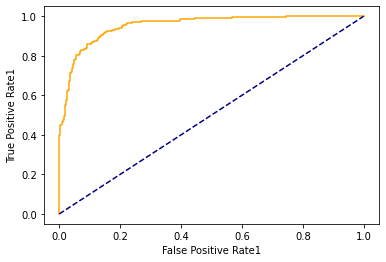

In [ ]:
from sklearn.metrics import roc_curve
from scipy import interp

fpr1, tpr1, threshold1 = roc_curve(test_labels1[:len(y_preds_test1)], y_preds_test1)
resnet_spectrogram_1024_2480_epoch40_fpr_tpr1 = [fpr1, tpr1]

tprs1 = []
base_fpr1 = np.linspace(0, 1, 101)

#plt.plot(feature_set36_1024_2480_epoch40_fpr_tpr[0], feature_set36_1024_2480_epoch40_fpr_tpr[1], 'r')
#plt.plot(feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[0], feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[1], 'b')
plt.plot(resnet_spectrogram_1024_2480_epoch40_fpr_tpr1[0], resnet_spectrogram_1024_2480_epoch40_fpr_tpr1[1], 'orange')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#tpr = interp(base_fpr, fpr, tpr)
#tpr[0] = 0.0
#tprs.append(tpr)
plt.ylabel('True Positive Rate1')
plt.xlabel('False Positive Rate1')
plt.show()

pickle.dump( resnet_spectrogram_1024_2480_epoch40_fpr_tpr1, open( "/content/drive/MyDrive/COVID19/resnet_spectrogram_5322_cenrolrms_30_e5.pickle", "wb" ) )


In [ ]:
from sklearn.metrics import classification_report
from keras import backend as K
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
keras.backend.clear_session()

adam = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

M_5322_ban_30_e5 = build_model7()

M_5322_ban_30_e5.compile(
    optimizer = adam,
    loss = 'BinaryCrossentropy',
    metrics=['accuracy'])



with tf.device('/device:GPU:0'):
  M_5322_ban_30_e5.fit(
      imgs_em7,
      epochs=30, #epochs 40,50,100
      validation_data=VAL7, 
      verbose=2)

print()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_val7  = val_labels7
y_preds_val7 = M_5322_ban_30_e5.predict(VAL7)
print('val7:', roc_auc_score(y_val7[:len(y_preds_val7)], y_preds_val7))

y_test7  = test_labels7
y_preds_test7 = M_5322_ban_30_e5.predict(TEST7)
print('test7', roc_auc_score(y_test7[:len(y_preds_test7)], y_preds_test7))

print()
print('-----------------------------------------------------------------')
    
    
M_5322_ban_30_e5.save('/content/drive/MyDrive/COVID19/M_5322_ban_30_e5.h5')


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


okb1
Epoch 1/30
77/77 - 98s - loss: 0.9541 - accuracy: 0.5482 - val_loss: 0.6466 - val_accuracy: 0.6250 - 98s/epoch - 1s/step
Epoch 2/30
77/77 - 44s - loss: 0.8173 - accuracy: 0.6071 - val_loss: 0.6331 - val_accuracy: 0.6784 - 44s/epoch - 572ms/step
Epoch 3/30
77/77 - 44s - loss: 0.6927 - accuracy: 0.6683 - val_loss: 0.7049 - val_accuracy: 0.5872 - 44s/epoch - 567ms/step
Epoch 4/30
77/77 - 44s - loss: 0.6192 - accuracy: 0.7086 - val_loss: 0.8831 - val_accuracy: 0.5729 - 44s/epoch - 572ms/step
Epoch 5/30
77/77 - 44s - loss: 0.5356 - accuracy: 0.7503 - val_loss: 1.0106 - val_accuracy: 0.5677 - 44s/epoch - 566ms/step
Epoch 6/30
77/77 - 44s - loss: 0.4269 - accuracy: 0.8106 - val_loss: 1.1281 - val_accuracy: 0.5677 - 44s/epoch - 567ms/step
Epoch 7/30
77/77 - 44s - loss: 0.3676 - accuracy: 0.8390 - val_loss: 1.3165 - val_accuracy: 0.5586 - 44s/epoch - 568ms/step
Epoch 8/30
77/77 - 44s - loss: 0.2882 - accuracy: 0.8723 - val_loss: 1.2839 - val_accuracy: 0.5638 - 44s/epoch - 569ms/step
Epoch 

In [ ]:
y_p_v7=[]
for i in range(len(y_preds_val7)):
    if y_preds_val7[i] >= 0.5:
        y_p_v7.append(1)
    else:
        y_p_v7.append(0)

print(classification_report(y_val7[:len(y_preds_val7)],y_p_v7))

y_p_t7 = []
for i in range(len(y_preds_test7)):
    if y_preds_test7[i] >= 0.5:
         y_p_t7.append(1)
    else:
        y_p_t7.append(0)

print(classification_report(y_test7[:len(y_preds_test7)],y_p_t7))


              precision    recall  f1-score   support

           0       0.87      0.91      0.89       422
           1       0.88      0.84      0.86       346

    accuracy                           0.88       768
   macro avg       0.88      0.87      0.87       768
weighted avg       0.88      0.88      0.88       768

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       405
           1       0.91      0.84      0.87       363

    accuracy                           0.88       768
   macro avg       0.89      0.88      0.88       768
weighted avg       0.88      0.88      0.88       768



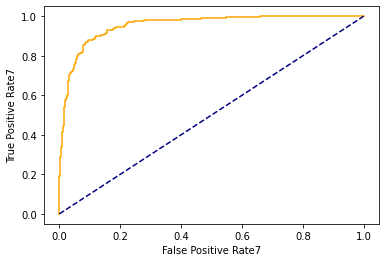

In [ ]:
from sklearn.metrics import roc_curve
from scipy import interp

fpr7, tpr7, threshold7 = roc_curve(test_labels7[:len(y_preds_test7)], y_preds_test7)
resnet_spectrogram_1024_2480_epoch40_fpr_tpr7 = [fpr7, tpr7]

tprs7 = []
base_fpr7 = np.linspace(0, 1, 101)

#plt.plot(feature_set36_1024_2480_epoch40_fpr_tpr[0], feature_set36_1024_2480_epoch40_fpr_tpr[1], 'r')
#plt.plot(feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[0], feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[1], 'b')
plt.plot(resnet_spectrogram_1024_2480_epoch40_fpr_tpr7[0], resnet_spectrogram_1024_2480_epoch40_fpr_tpr7[1], 'orange')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#tpr = interp(base_fpr, fpr, tpr)
#tpr[0] = 0.0
#tprs.append(tpr)
plt.ylabel('True Positive Rate7')
plt.xlabel('False Positive Rate7')
plt.show()
pickle.dump( resnet_spectrogram_1024_2480_epoch40_fpr_tpr7, open( "/content/drive/MyDrive/COVID19/resnet_spectrogram_5322_ban_30_e5.pickle", "wb" ) )


In [ ]:
from sklearn.metrics import classification_report
from keras import backend as K
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
keras.backend.clear_session()

adam = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

M_5322_banroll_30_e5 = build_model()

M_5322_banroll_30_e5.compile(
    optimizer = adam,
    loss = 'BinaryCrossentropy',
    metrics=['accuracy'])

tfeatures = DATA['MFCCS'][:int(0.7*data_len)]
timgs     = DATA['MEL'][:int(0.7*data_len)]
labels    = DATA['LABELS'][:int(0.7*data_len)]

test_features= DATA['MFCCS'][ int(0.7*data_len): int(0.85*data_len)]
test_imgs    = DATA['MEL'][ int(0.7*data_len): int(0.85*data_len)]
test_labels  = DATA['LABELS'][ int(0.7*data_len): int(0.85*data_len)]
                                        
val_features= DATA['MFCCS'][ int(0.85*data_len) :]
val_imgs    = DATA['MEL'][ int(0.85*data_len) :]
val_labels  = DATA['LABELS'][ int(0.85*data_len) :]
#print(tfeatures.shape)

   

imgs_em      = TripleInputGenerator(tfeatures,timgs, labels,batch_size=48,target_size=(224,224))
TEST          = TripleInputGenerator(test_features,test_imgs, test_labels,batch_size=48,target_size=(224,224))
VAL         = TripleInputGenerator(val_features,val_imgs, val_labels,batch_size=48,target_size=(224,224))



with tf.device('/device:GPU:0'):
  M_5322_banroll_30_e5.fit(
      imgs_em,
      epochs=30, #epochs 40,50,100
      validation_data=VAL, 
      verbose=2)


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_val  = val_labels
y_preds_val = M_5322_banroll_30_e5.predict(VAL)
print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

y_test  = test_labels
y_preds_test = M_5322_banroll_30_e5.predict(TEST)
print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))

print()
print('-----------------------------------------------------------------')
    
    
    
M_5322_banroll_30_e5.save('/content/drive/MyDrive/COVID19/M_5322_banroll_30_e5.h5')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


okb1
Epoch 1/30
77/77 - 53s - loss: 1.0208 - accuracy: 0.5152 - val_loss: 0.8025 - val_accuracy: 0.4583 - 53s/epoch - 692ms/step
Epoch 2/30
77/77 - 44s - loss: 0.8740 - accuracy: 0.5806 - val_loss: 0.8766 - val_accuracy: 0.4596 - 44s/epoch - 565ms/step
Epoch 3/30
77/77 - 44s - loss: 0.7365 - accuracy: 0.6569 - val_loss: 0.7186 - val_accuracy: 0.4974 - 44s/epoch - 568ms/step
Epoch 4/30
77/77 - 44s - loss: 0.6498 - accuracy: 0.7037 - val_loss: 0.7756 - val_accuracy: 0.4961 - 44s/epoch - 565ms/step
Epoch 5/30
77/77 - 44s - loss: 0.5498 - accuracy: 0.7495 - val_loss: 0.8789 - val_accuracy: 0.4870 - 44s/epoch - 566ms/step
Epoch 6/30
77/77 - 44s - loss: 0.4526 - accuracy: 0.7914 - val_loss: 0.7921 - val_accuracy: 0.4961 - 44s/epoch - 570ms/step
Epoch 7/30
77/77 - 44s - loss: 0.3733 - accuracy: 0.8347 - val_loss: 0.8883 - val_accuracy: 0.4870 - 44s/epoch - 566ms/step
Epoch 8/30
77/77 - 43s - loss: 0.3110 - accuracy: 0.8585 - val_loss: 0.9433 - val_accuracy: 0.4766 - 43s/epoch - 564ms/step
Epo

In [ ]:
y_p_v=[]
for i in range(len(y_preds_val)):
    if y_preds_val[i] >= 0.5:
        y_p_v.append(1)
    else:
        y_p_v.append(0)

print(classification_report(y_val[:len(y_preds_val)],y_p_v))

y_p_t = []
for i in range(len(y_preds_test)):
    if y_preds_test[i] >= 0.5:
         y_p_t.append(1)
    else:
        y_p_t.append(0)

print(classification_report(y_test[:len(y_preds_test)],y_p_t))


              precision    recall  f1-score   support

           0       0.90      0.91      0.90       416
           1       0.89      0.88      0.88       352

    accuracy                           0.89       768
   macro avg       0.89      0.89      0.89       768
weighted avg       0.89      0.89      0.89       768

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       410
           1       0.89      0.88      0.88       358

    accuracy                           0.89       768
   macro avg       0.89      0.89      0.89       768
weighted avg       0.89      0.89      0.89       768



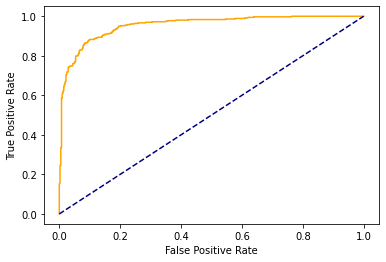

In [ ]:
from sklearn.metrics import roc_curve
from scipy import interp

fpr, tpr, threshold = roc_curve(test_labels[:len(y_preds_test)], y_preds_test)
resnet_spectrogram_1024_2480_epoch40_fpr_tpr = [fpr, tpr]

tprs = []
base_fpr = np.linspace(0, 1, 101)

#plt.plot(feature_set36_1024_2480_epoch40_fpr_tpr[0], feature_set36_1024_2480_epoch40_fpr_tpr[1], 'r')
#plt.plot(feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[0], feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[1], 'b')
plt.plot(resnet_spectrogram_1024_2480_epoch40_fpr_tpr[0], resnet_spectrogram_1024_2480_epoch40_fpr_tpr[1], 'orange')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#tpr = interp(base_fpr, fpr, tpr)
#tpr[0] = 0.0
#tprs.append(tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

pickle.dump( resnet_spectrogram_1024_2480_epoch40_fpr_tpr, open( "/content/drive/MyDrive/COVID19/resnet_spectrogram_5322_banroll_30_e5.pickle", "wb" ) )


In [ ]:
from sklearn.metrics import classification_report
from keras import backend as K
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
keras.backend.clear_session()

adam = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


M_5322_cen_30_e5 = build_model7()

M_5322_cen_30_e5.compile(
    optimizer = adam,
    loss = 'BinaryCrossentropy',
    metrics=['accuracy'])



with tf.device('/device:GPU:0'):
    M_5322_cen_30_e5.fit(
        imgs_em1,
        epochs=30, #epochs 40,50,100
        validation_data=VAL1, 
        verbose=2)


print()

print()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

val1  = val_labels1
preds_val1 = M_5322_cen_30_e5.predict(VAL1)
print('val1:', roc_auc_score(val1[:len(preds_val1)], preds_val1))

test1 = test_labels1
preds_test1 = M_5322_cen_30_e5.predict(TEST1)
print('test1', roc_auc_score(test1[:len(preds_test1)], preds_test1))

print()
print('-----------------------------------------------------------------')
    
    
    
M_5322_cen_30_e5.save('/content/drive/MyDrive/COVID19/M_5322_cen_30_e5.h5')



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


okb1
Epoch 1/30
77/77 - 54s - loss: 0.9887 - accuracy: 0.5216 - val_loss: 0.7709 - val_accuracy: 0.5182 - 54s/epoch - 695ms/step
Epoch 2/30
77/77 - 44s - loss: 0.8315 - accuracy: 0.5852 - val_loss: 1.0913 - val_accuracy: 0.4844 - 44s/epoch - 566ms/step
Epoch 3/30
77/77 - 44s - loss: 0.7464 - accuracy: 0.6391 - val_loss: 1.5350 - val_accuracy: 0.4844 - 44s/epoch - 571ms/step
Epoch 4/30
77/77 - 44s - loss: 0.6372 - accuracy: 0.7027 - val_loss: 1.0376 - val_accuracy: 0.4844 - 44s/epoch - 566ms/step
Epoch 5/30
77/77 - 44s - loss: 0.5572 - accuracy: 0.7440 - val_loss: 0.6949 - val_accuracy: 0.5391 - 44s/epoch - 574ms/step
Epoch 6/30
77/77 - 43s - loss: 0.4787 - accuracy: 0.7841 - val_loss: 0.7352 - val_accuracy: 0.5339 - 43s/epoch - 565ms/step
Epoch 7/30
77/77 - 44s - loss: 0.3741 - accuracy: 0.8295 - val_loss: 0.6932 - val_accuracy: 0.5534 - 44s/epoch - 568ms/step
Epoch 8/30
77/77 - 44s - loss: 0.3075 - accuracy: 0.8636 - val_loss: 0.7160 - val_accuracy: 0.5469 - 44s/epoch - 568ms/step
Epo

In [ ]:
y_p_v1=[]
for i in range(len(preds_val1)):
    if preds_val1[i] >= 0.5:
        y_p_v1.append(1)
    else:
        y_p_v1.append(0)

print(classification_report(val1[:len(preds_val1)],y_p_v1))

y_p_t1 = []
for i in range(len(preds_test1)):
    if preds_test1[i] >= 0.5:
         y_p_t1.append(1)
    else:
        y_p_t1.append(0)

print(classification_report(test1[:len(preds_test1)],y_p_t1))


              precision    recall  f1-score   support

           0       0.93      0.85      0.89       396
           1       0.85      0.93      0.89       372

    accuracy                           0.89       768
   macro avg       0.89      0.89      0.89       768
weighted avg       0.89      0.89      0.89       768

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       416
           1       0.81      0.92      0.86       352

    accuracy                           0.86       768
   macro avg       0.87      0.87      0.86       768
weighted avg       0.87      0.86      0.86       768



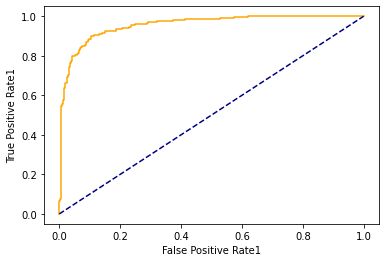

In [ ]:
from sklearn.metrics import roc_curve
from scipy import interp

fpr0, tpr0, threshold0 = roc_curve(test_labels1[:len(preds_test1)], preds_test1)
resnet_spectrogram_1024_2480_epoch40_fpr_tpr0 = [fpr0, tpr0]

tprs1 = []
base_fpr1 = np.linspace(0, 1, 101)

#plt.plot(feature_set36_1024_2480_epoch40_fpr_tpr[0], feature_set36_1024_2480_epoch40_fpr_tpr[1], 'r')
#plt.plot(feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[0], feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[1], 'b')
plt.plot(resnet_spectrogram_1024_2480_epoch40_fpr_tpr0[0], resnet_spectrogram_1024_2480_epoch40_fpr_tpr0[1], 'orange')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#tpr = interp(base_fpr, fpr, tpr)
#tpr[0] = 0.0
#tprs.append(tpr)
plt.ylabel('True Positive Rate1')
plt.xlabel('False Positive Rate1')
plt.show()

pickle.dump( resnet_spectrogram_1024_2480_epoch40_fpr_tpr0, open( "/content/drive/MyDrive/COVID19/resnet_spectrogram_5322_cen_30_e5.pickle", "wb" ) )
